# A. Markovich, N. Puchkin
# Numerical experiments on audio recording CENSREC-1-C data set, described in the paper
# "Score-based change point detection via tracking the best of infinitely many experts"

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from numpy.random import normal as randn, multivariate_normal as randmn
import pandas as pd
from scipy.io.wavfile import read
from sklearn.preprocessing import StandardScaler
from collections.abc import Iterable
import matplotlib.ticker as mtick

from algorithms.score_based import *
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

### Auxiliary function 

In [2]:
def compute_delays_false_alarms(runs, S_list, threshold, tau):
    delays = []
    false_alarms = 0
    not_detected = 0

    for i in range(runs):

        S = S_list[i]
        res = np.ma.flatnotmasked_edges(np.ma.masked_array(S, S <= threshold))
        if isinstance(res, Iterable):
            imin, _ = res
            if imin - tau[i] < 0:
                print(imin, i)
                false_alarms += 1
            else:
                delays.append(imin - tau[i])
        else:
            not_detected +=1

    if not_detected == runs:
        return 0, 0, 0, not_detected

    delays = np.array(delays)
    mean_delay = np.round(delays.mean(), 1)
    std_delay = np.round(delays.std(), 1)

    return false_alarms, mean_delay, std_delay, not_detected

## CENSREC-1-C clean 

24801
[  410  2835  6147  7891 10347 12974 15967 18682 21128 23620]


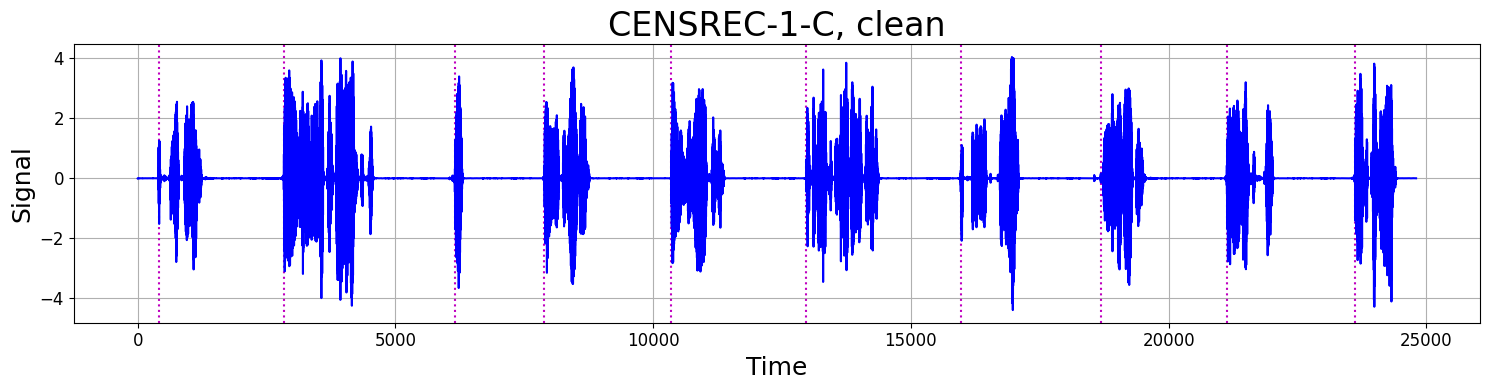

In [3]:
input_data = read('data/CENSREC/MAH_clean.wav')
audio = input_data[1]
# Data preprocessing

# Scaling
scaler = StandardScaler()
audio_scaled = scaler.fit_transform(audio.reshape(-1, 1)) 
audio_scaled = audio_scaled.reshape(-1)

# Reduce the data, averaging over 10 values
bandwidth = 10
N = audio_scaled.shape[0] // bandwidth

data = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(audio_scaled[bandwidth * t : bandwidth * (t + 1)]))
    
print(data.shape[0])

change_points = [410, 2835, 6147, 7891, 10347, 12974, 15967, 18682, 21128, 23620]
change_points = np.array(change_points)
print(change_points)
plt.figure(figsize=(15, 4))

for c in change_points:
    plt.axvline(c, c='m', ls=':')

plt.plot(np.arange(len(data)), data, c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='CENSREC-1-C, clean', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.tight_layout()



In [4]:

# Test part: check the performance of the procedures
test_start = [10250, 12870, 15850, 18580, 21020, 23520]
test_end = [10450, 13070, 16050, 18780, 21220, 23720]
data_test = [data[test_start[i]:test_end[i]] for i in range(len(test_start))]

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

# test cps for plot
cptest = []
l = 0
for i in range(len(change_points_test)):
    cptest += [change_points_test[i] + l]
    l += data_test[0].shape[0]

# test data for plot
test_for_plot = np.hstack([data_test[i] for i in range(len(change_points_test))])
tick_cps_labels = np.array(test_start) + np.array(change_points_test)

Test change points: [ 97 104 117 102 108 100]


### Calculate test statistic

In [5]:
# Score-based

# The list of hyperparameters
eta = 0.1
l = 0.2
a = 1e-5
z = 1e-5

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

dim=1
S_q_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
    new_S_q, _ = model.run(data_test[i].reshape(-1, 1), eta)  

    S_q_list[i] = new_S_q


false_alarms_q, dd_mean_q, dd_std_q, not_detected_q = compute_delays_false_alarms(len(data_test), S_q_list, z, change_points_test)
print(f'Score-based quadratic, threshold={z}, eta={eta}, lambda = {l}, alpha={a}', '. FA:', false_alarms_q,\
                '; DD:', dd_mean_q, '±',dd_std_q,\
                '; ND:', not_detected_q)

s_q_test = np.hstack(S_q_list)


Test change points: [ 97 104 117 102 108 100]
115 2
Score-based quadratic, threshold=1e-05, eta=0.1, lambda = 0.2, alpha=1e-05 . FA: 1 ; DD: 1.0 ± 0.6 ; ND: 0


In [6]:
# FALCON

b =0.2
z = 0.7181051648770866
p=5

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    

# Initialization of the test statistic
S_ftal_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    new_S_ftal, _ = compute_test_stat_ftal(data_test[i], p, beta=b,\
                                                    design='hermite')
    S_ftal_list[i] = new_S_ftal

fa_ftal, dd_mean_ftal, dd_std_ftal, not_detected_ftal = compute_delays_false_alarms(len(data_test), S_ftal_list, z, change_points_test)

print(f'FTAL, beta = {b}, p={p}', '. Number of false alarms:', fa_ftal,\
    '; average delay:', dd_mean_ftal, '±', dd_std_ftal,\
    '; non-detected:', not_detected_ftal)

s_ftal_test = np.hstack(S_ftal_list)



Test change points: [ 97 104 117 102 108 100]
FTAL, beta = 0.2, p=5 . Number of false alarms: 0 ; average delay: 7.8 ± 14.4 ; non-detected: 0


In [7]:
# KLIEP

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
sigma = 1
z = 0

# Initialization of the test statistic
S_kliep_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    new_S_kliep, _ = compute_test_stat_kliep(data_test[i], window_size=50, sigma=sigma)
    S_kliep_list[i] = new_S_kliep

fa_kliep, dd_mean_kliep, dd_std_kliep, not_detected_kliep = compute_delays_false_alarms(len(data_test), S_kliep_list, z, change_points_test)

print(f'KlIEP, sigma = {sigma}', '. Number of false alarms:', fa_kliep,\
    '; average delay:', dd_mean_kliep, '±', dd_std_kliep,\
    '; non-detected:', not_detected_kliep)

s_kliep_test = np.hstack(S_kliep_list)


Test change points: [ 97 104 117 102 108 100]
101 3
KlIEP, sigma = 1 . Number of false alarms: 1 ; average delay: 6.2 ± 4.9 ; non-detected: 0


In [8]:
# M-statistic

sigma = 0.25
z =0.1127895254842545


# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    

# Initialization of the test statistic
S_mmd_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    new_S_mmd, _ = compute_test_stat_mmd(data_test[i], window_size=50, sigma=sigma)
    S_mmd_list[i] = new_S_mmd

fa_mmd, dd_mean_mmd, dd_std_mmd, not_detected_mmd = compute_delays_false_alarms(len(data_test), S_mmd_list, z, change_points_test)

print(f'M-statistic, sigma = {sigma}', '. Number of false alarms:', fa_mmd,\
    '; average delay:', dd_mean_mmd, '±', dd_std_mmd,\
    '; non-detected:', not_detected_mmd)

s_mmd_test = np.hstack(S_mmd_list)



Test change points: [ 97 104 117 102 108 100]
M-statistic, sigma = 0.25 . Number of false alarms: 0 ; average delay: 2.5 ± 3.2 ; non-detected: 0


### PLOT

In [25]:
z_q = 1e-5
z_ftal =0.7181051648770866
z_kliep = 1e-8
z_mmd = 0.1127895254842545

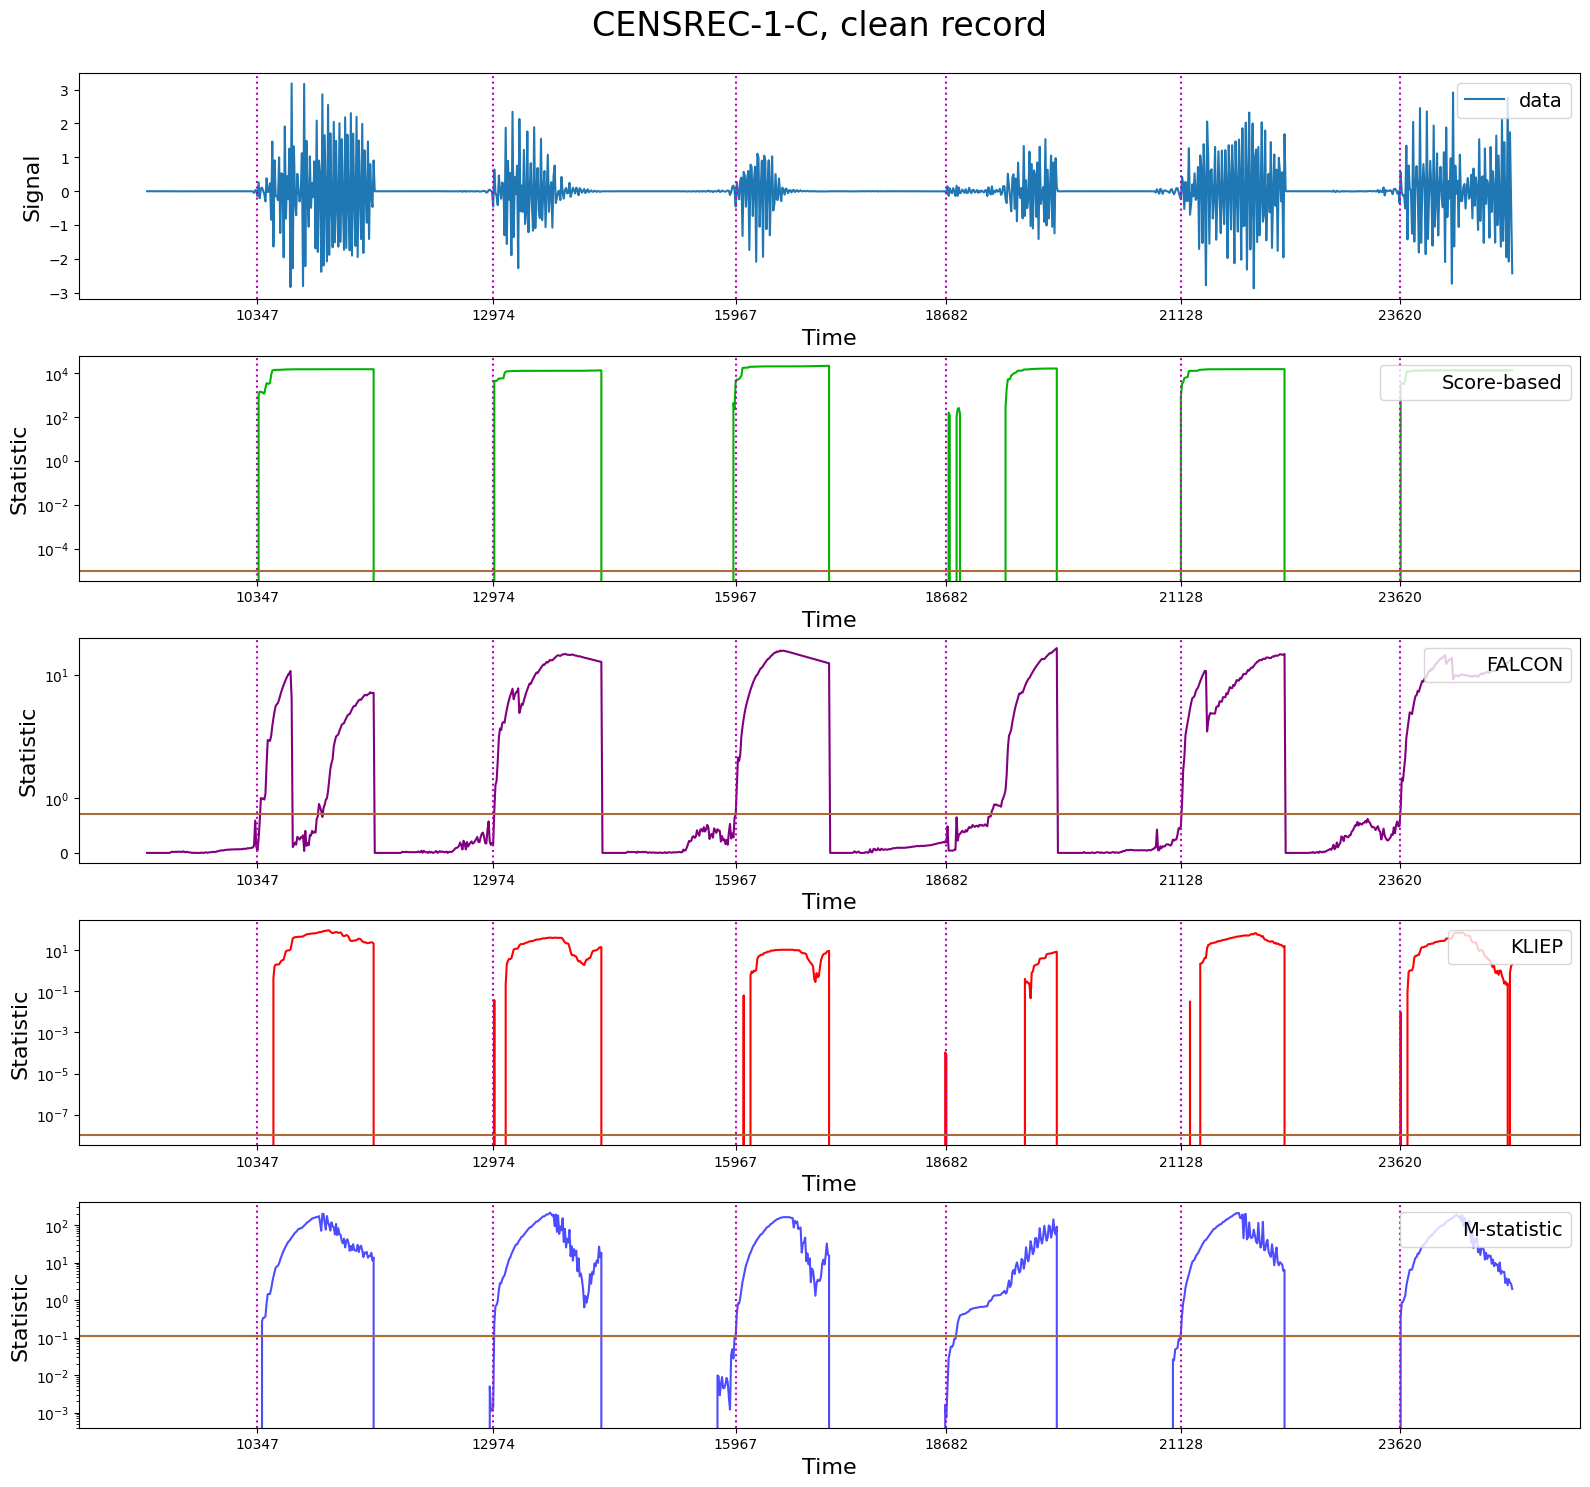

In [28]:
f, ax = plt.subplots(5, 1, figsize=(16, 15))

plt.suptitle(t='CENSREC-1-C, clean record', fontsize=24, y=0.98)

f.tight_layout(pad=2.0)

ax[0].plot(test_for_plot, label='data')


ax[1].plot(s_q_test, c='#00b300')
ax[1].axhline(z_q, c='#aa6c39')
ax[1].plot(z_q, lw=0, label="Score-based")
# ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) 
ax[1].set_yscale('log')

ax[2].plot(s_ftal_test, c='purple')
ax[2].axhline(z_ftal, c='#aa6c39')
ax[2].plot(z_ftal, lw=0, label="FALCON")
ax[2].set_yscale('symlog')

ax[3].plot(s_kliep_test, c='red')
ax[3].axhline(z_kliep, c='#aa6c39')
ax[3].plot(z_kliep, lw=0, label="KLIEP")
ax[3].set_yscale('log')

ax[4].plot(s_mmd_test, c='#4d4dff')
ax[4].axhline(z_mmd, c='#aa6c39')
ax[4].plot(z_mmd, lw=0, label="M-statistic")
ax[4].set_yscale('log')

for i in range(5):
    for c in cptest:
        ax[i].axvline(c, c='m', ls=':')
    ax[i].set_xticks(cptest, tick_cps_labels)
    if i == 0:
        ax[i].set_ylabel('Signal', fontsize=16)
    else:
        ax[i].set_ylabel('Statistic', fontsize=16)
    ax[i].set_xlabel('Time', fontsize=16)
    ax[i].legend(loc='upper right', fontsize=14)
plt.show()


## CENSREC-1-C SNR 15

24801
[  410  2835  6147  7891 10347 12974 15967 18682 21128 23620]


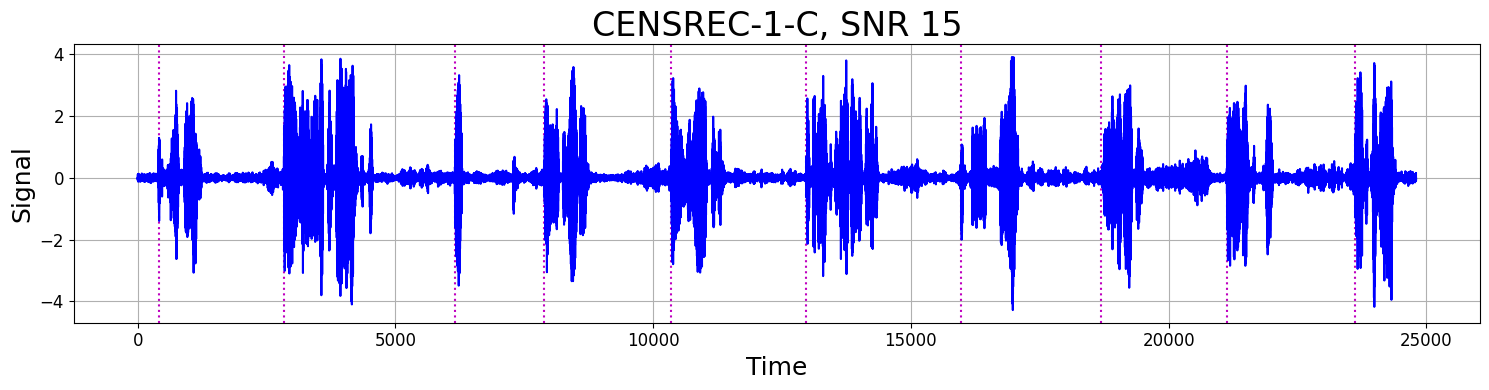

In [29]:
# Read the data
input_data = read('data/CENSREC/MAH_N1_SNR15.wav')
audio = input_data[1]

# Data preprocessing

# Scaling
scaler = StandardScaler()
audio_scaled = scaler.fit_transform(audio.reshape(-1, 1))
audio_scaled = audio_scaled.reshape(-1)

# Reduce the data, averaging over 10 values
bandwidth = 10
N = audio_scaled.shape[0] // bandwidth

data = np.empty(0)

for t in range(N):
    data = np.append(data, np.mean(audio_scaled[bandwidth * t : bandwidth * (t + 1)]))
    
print(data.shape[0])

change_points = [410, 2835, 6147, 7891, 10347, 12974, 15967, 18682, 21128, 23620]
change_points = np.array(change_points)
print(change_points)
plt.figure(figsize=(15, 4))

for c in change_points:
    plt.axvline(c, c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data, c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='CENSREC-1-C, SNR 15', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.tight_layout()


In [30]:
# Split the data into the stationary part, validation part, and test part

# Test part: check the performance of the procedures
test_start = [10250, 12870, 15850, 18580, 21020, 23520]
test_end = [10450, 13070, 16050, 18780, 21220, 23720]
data_test = [data[test_start[i]:test_end[i]] for i in range(len(test_start))]

In [31]:
# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

# test cps for plot
cptest = []
l = 0
for i in range(len(change_points_test)):
    cptest += [change_points_test[i] + l]
    l += data_test[0].shape[0]

# test data for plot
test_for_plot = np.hstack([data_test[i] for i in range(len(change_points_test))])
tick_cps_labels = np.array(test_start) + np.array(change_points_test)

Test change points: [ 97 104 117 102 108 100]


### Calculate test statistic 

In [32]:
# Score-based

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

# Initialization of the delays array and
# the false alarms counter


# The list of hyperparameters
eta = 0.05
l = 0.5
a = 1e-5
z = 1e-10


dim=1
S_q_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
    new_S_q, _ = model.run(data_test[i].reshape(-1, 1), eta)  

    S_q_list[i] = new_S_q


false_alarms_q, dd_mean_q, dd_std_q, not_detected_q = compute_delays_false_alarms(len(data_test), S_q_list, z, change_points_test)
print(f'Score-based quadratic, threshold={z}, eta={eta}, lambda = {l}, alpha={a}', '. FA:', false_alarms_q,\
                '; DD:', dd_mean_q, '±',dd_std_q,\
                '; ND:', not_detected_q)

s_q_test = np.hstack(S_q_list)


Test change points: [ 97 104 117 102 108 100]
Score-based quadratic, threshold=1e-10, eta=0.05, lambda = 0.5, alpha=1e-05 . FA: 0 ; DD: 11.2 ± 13.5 ; ND: 0


In [33]:
# FALCON

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
p=5
b =0.01
z =4

# Initialization of the test statistic
S_ftal_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    new_S_ftal, _ = compute_test_stat_ftal(data_test[i], p, beta=b,\
                                                    design='hermite')
    S_ftal_list[i] = new_S_ftal

fa_ftal, dd_mean_ftal, dd_std_ftal, not_detected_ftal = compute_delays_false_alarms(len(data_test), S_ftal_list, z, change_points_test)

print(f'FTAL, beta = {b}, p={p}', '. Number of false alarms:', fa_ftal,\
    '; average delay:', dd_mean_ftal, '±', dd_std_ftal,\
    '; non-detected:', not_detected_ftal)

s_ftal_test = np.hstack(S_ftal_list)


Test change points: [ 97 104 117 102 108 100]
FTAL, beta = 0.01, p=5 . Number of false alarms: 0 ; average delay: 14.3 ± 10.8 ; non-detected: 0


In [46]:
# KLIEP

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
sigma = 0.75
z = 0.1347

# Initialization of the test statistic
S_kliep_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    new_S_kliep, _ = compute_test_stat_kliep(data_test[i], window_size=50, sigma=sigma)
    S_kliep_list[i] = new_S_kliep

fa_kliep, dd_mean_kliep, dd_std_kliep, not_detected_kliep = compute_delays_false_alarms(len(data_test), S_kliep_list, z, change_points_test)

print(f'KlIEP, sigma = {sigma}', '. Number of false alarms:', fa_kliep,\
    '; average delay:', dd_mean_kliep, '±', dd_std_kliep,\
    '; non-detected:', not_detected_kliep)

s_kliep_test = np.hstack(S_kliep_list)


Test change points: [ 97 104 117 102 108 100]
KlIEP, sigma = 0.75 . Number of false alarms: 0 ; average delay: 19.5 ± 20.1 ; non-detected: 0


In [47]:
# M-statistic

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
sigma = 1.2
z = 0.11168690974305112

# Initialization of the test statistic
S_mmd_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    new_S_mmd, _ = compute_test_stat_mmd(data_test[i], window_size=50, sigma=sigma)
    S_mmd_list[i] = new_S_mmd

fa_mmd, dd_mean_mmd, dd_std_mmd, not_detected_mmd = compute_delays_false_alarms(len(data_test), S_mmd_list, z, change_points_test)

print(f'M-statistic, sigma = {sigma}', '. Number of false alarms:', fa_mmd,\
    '; average delay:', dd_mean_mmd, '±', dd_std_mmd,\
    '; non-detected:', not_detected_mmd)

s_mmd_test = np.hstack(S_mmd_list)


Test change points: [ 97 104 117 102 108 100]
M-statistic, sigma = 1.2 . Number of false alarms: 0 ; average delay: 16.7 ± 16.8 ; non-detected: 0


### PLOT

In [37]:
z_q = 1e-10
z_ftal =4
z_kliep = 0.1347
z_mmd = 0.11168690974305112

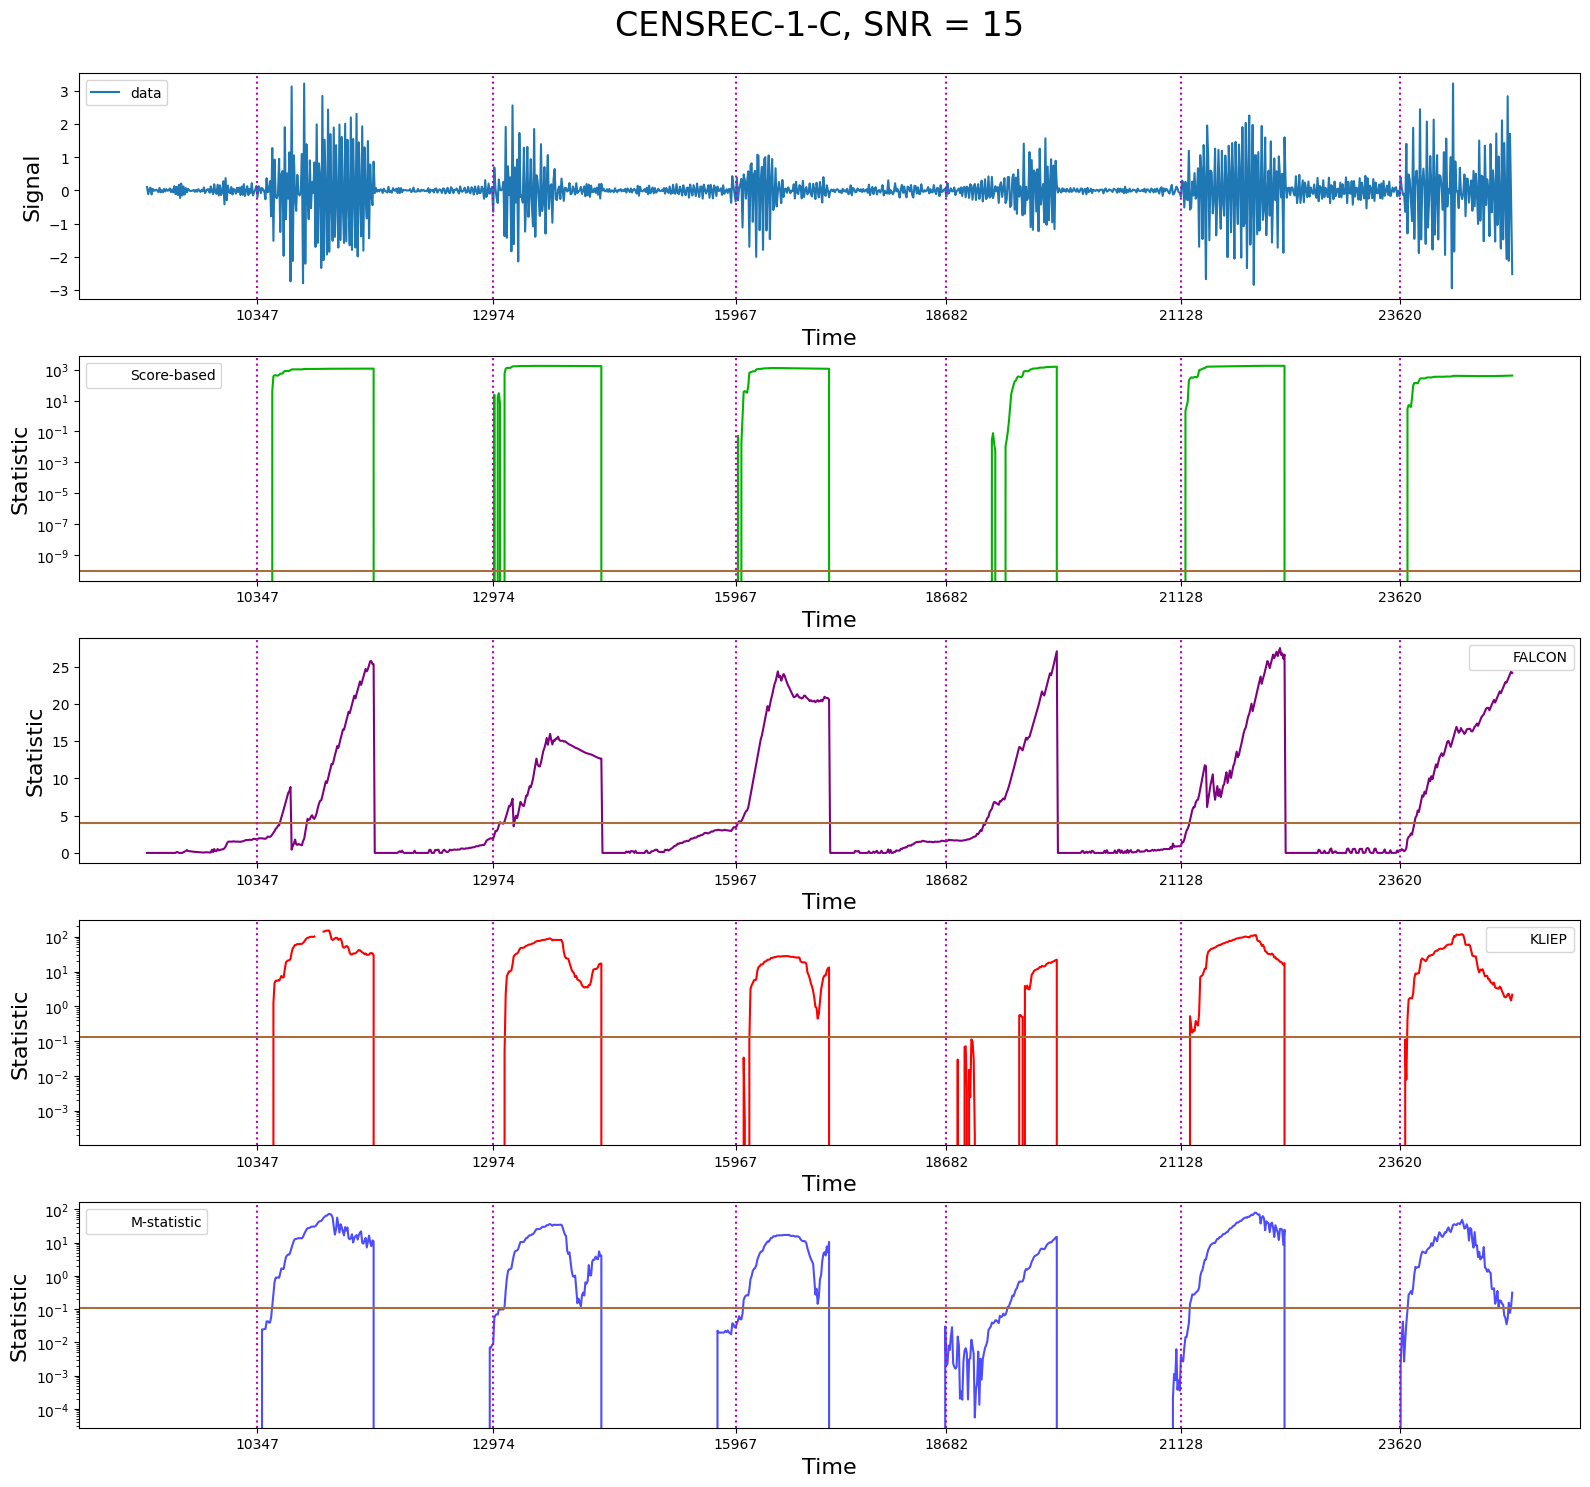

In [48]:
f, ax = plt.subplots(5, 1, figsize=(16, 15))

plt.suptitle(t='CENSREC-1-C, SNR = 15', fontsize=24, y=0.98)
f.tight_layout(pad=2.0)

ax[0].plot(test_for_plot, label='data')


ax[1].plot(s_q_test, c='#00b300')
ax[1].axhline(z_q, c='#aa6c39')
ax[1].plot(z_q, lw=0, label="Score-based")
# ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) 
ax[1].set_yscale('log')


ax[2].plot(s_ftal_test, c='purple')
ax[2].axhline(z_ftal, c='#aa6c39')
ax[2].plot(z_ftal, lw=0, label="FALCON")


ax[3].plot(s_kliep_test, c='red')
ax[3].axhline(z_kliep, c='#aa6c39')
ax[3].plot(z_kliep, lw=0, label="KLIEP")
ax[3].set_yscale('log')

ax[4].plot(s_mmd_test, c='#4d4dff')
ax[4].axhline(z_mmd, c='#aa6c39')
ax[4].plot(z_mmd, lw=0, label="M-statistic")
ax[4].set_yscale('log')


for i in range(5):
    for c in cptest:
        ax[i].axvline(c, c='m', ls=':')
    ax[i].set_xticks(cptest, tick_cps_labels)
    if i == 0:
        ax[i].set_ylabel('Signal', fontsize=16)
    else:
        ax[i].set_ylabel('Statistic', fontsize=16)
    ax[i].set_xlabel('Time', fontsize=16)
    # ax[i].grid()

    
    
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()

plt.show()


## CENSREC-1-C SNR 20

24801
[  410  2835  6147  7891 10347 12974 15967 18682 21128 23620]


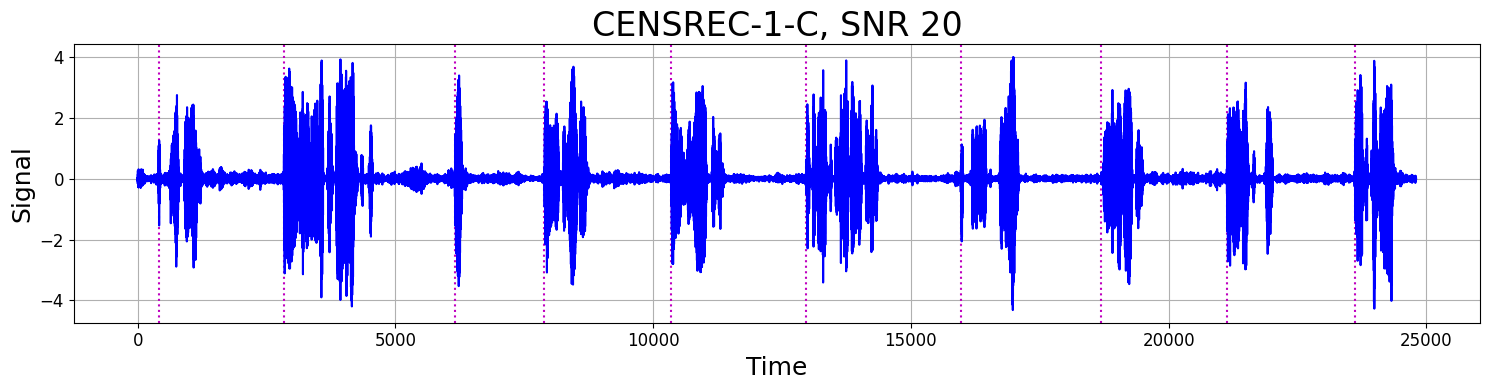

In [49]:
# Read the data
input_data = read('data/CENSREC/MAH_N1_SNR20.wav')
audio = input_data[1]


# Data preprocessing

# Scaling
scaler = StandardScaler()
audio_scaled = scaler.fit_transform(audio.reshape(-1, 1))
audio_scaled = audio_scaled.reshape(-1)

# Reduce the data, averaging over 10 values
bandwidth = 10
N = audio_scaled.shape[0] // bandwidth

data = np.empty(0)

for t in range(N):
    data = np.append(data, np.mean(audio_scaled[bandwidth * t : bandwidth * (t + 1)]))
    
print(data.shape[0])

change_points = [410, 2835, 6147, 7891, 10347, 12974, 15967, 18682, 21128, 23620]
change_points = np.array(change_points)
print(change_points)
plt.figure(figsize=(15, 4))

for c in change_points:
    plt.axvline(c, c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data, c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='CENSREC-1-C, SNR 20', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.tight_layout()

In [50]:
# Test part: check the performance of the procedures
test_start = [10250, 12870, 15850, 18580, 21020, 23520]
test_end = [10450, 13070, 16050, 18780, 21220, 23720]
data_test = [data[test_start[i]:test_end[i]] for i in range(len(test_start))]

In [51]:
# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

# test cps for plot
cptest = []
l = 0
for i in range(len(change_points_test)):
    cptest += [change_points_test[i] + l]
    l += data_test[0].shape[0]

# test data for plot
test_for_plot = np.hstack([data_test[i] for i in range(len(change_points_test))])
tick_cps_labels = np.array(test_start) + np.array(change_points_test)

Test change points: [ 97 104 117 102 108 100]


### Calculate test statistic 

In [52]:
# Score-based

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)


dim=1
eta = 0.15
l = 1
a = 1e-4
z = 1e-5

S_list=np.empty((len(change_points_test), data_test[0].shape[0]))
# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
    new_S_q, _ = model.run(data_test[i].reshape(-1, 1), eta)      
    
    S_list[i] = new_S_q

false_alarms_q, dd_mean_q, dd_std_q, not_detected_q = compute_delays_false_alarms(len(change_points_test), S_list, z, change_points_test)
print(f'Score-based quadratic, eta={eta}, lambda = {l}, alpha={a}', '. FA:', false_alarms_q,\
                '; DD:', dd_mean_q, '±', dd_std_q,\
                '; ND:', not_detected_q)

s_q_test = np.hstack(S_list)


Test change points: [ 97 104 117 102 108 100]
Score-based quadratic, eta=0.15, lambda = 1, alpha=0.0001 . FA: 0 ; DD: 10.7 ± 19.0 ; ND: 0


In [53]:
# FALCON

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
p=5
b =5
z = 0.5361798574510446

# Initialization of the test statistic
S_ftal_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    new_S_ftal, _ = compute_test_stat_ftal(data_test[i], p, beta=b,\
                                                    design='hermite')
    S_ftal_list[i] = new_S_ftal

fa_ftal, dd_mean_ftal, dd_std_ftal, not_detected_ftal = compute_delays_false_alarms(len(data_test), S_ftal_list, z, change_points_test)

print(f'FTAL, beta = {b}, p={p}', '. Number of false alarms:', fa_ftal,\
    '; average delay:', dd_mean_ftal, '±', dd_std_ftal,\
    '; non-detected:', not_detected_ftal)

s_ftal_test = np.hstack(S_ftal_list)

Test change points: [ 97 104 117 102 108 100]
FTAL, beta = 5, p=5 . Number of false alarms: 0 ; average delay: 18.0 ± 19.0 ; non-detected: 0


In [54]:
# KLIEP

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
sigma = 0.01
z = 80.588

# Initialization of the test statistic
S_kliep_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    new_S_kliep, _ = compute_test_stat_kliep(data_test[i], window_size=50, sigma=sigma)
    S_kliep_list[i] = new_S_kliep

fa_kliep, dd_mean_kliep, dd_std_kliep, not_detected_kliep = compute_delays_false_alarms(len(data_test), S_kliep_list, z, change_points_test)

print(f'KlIEP, sigma = {sigma}', '. Number of false alarms:', fa_kliep,\
    '; average delay:', dd_mean_kliep, '±', dd_std_kliep,\
    '; non-detected:', not_detected_kliep)

s_kliep_test = np.hstack(S_kliep_list)

Test change points: [ 97 104 117 102 108 100]
KlIEP, sigma = 0.01 . Number of false alarms: 0 ; average delay: 20.3 ± 14.2 ; non-detected: 0


In [55]:
# M-statistic

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
sigma = 5
z =  0.0015263208542457476

# Initialization of the test statistic
S_mmd_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    new_S_mmd, _ = compute_test_stat_mmd(data_test[i], window_size=50, sigma=sigma)
    S_mmd_list[i] = new_S_mmd

fa_mmd, dd_mean_mmd, dd_std_mmd, not_detected_mmd = compute_delays_false_alarms(len(data_test), S_mmd_list, z, change_points_test)

print(f'M-statistic, sigma = {sigma}', '. Number of false alarms:', fa_mmd,\
    '; average delay:', dd_mean_mmd, '±', dd_std_mmd,\
    '; non-detected:', not_detected_mmd)

s_mmd_test = np.hstack(S_mmd_list)

Test change points: [ 97 104 117 102 108 100]
M-statistic, sigma = 5 . Number of false alarms: 0 ; average delay: 18.3 ± 20.1 ; non-detected: 0


### PLOT

In [299]:
z_q = 1e-5
z_ftal =  0.5361798574510446
z_kliep = 80.588
z_mmd = 0.0015263208542457476


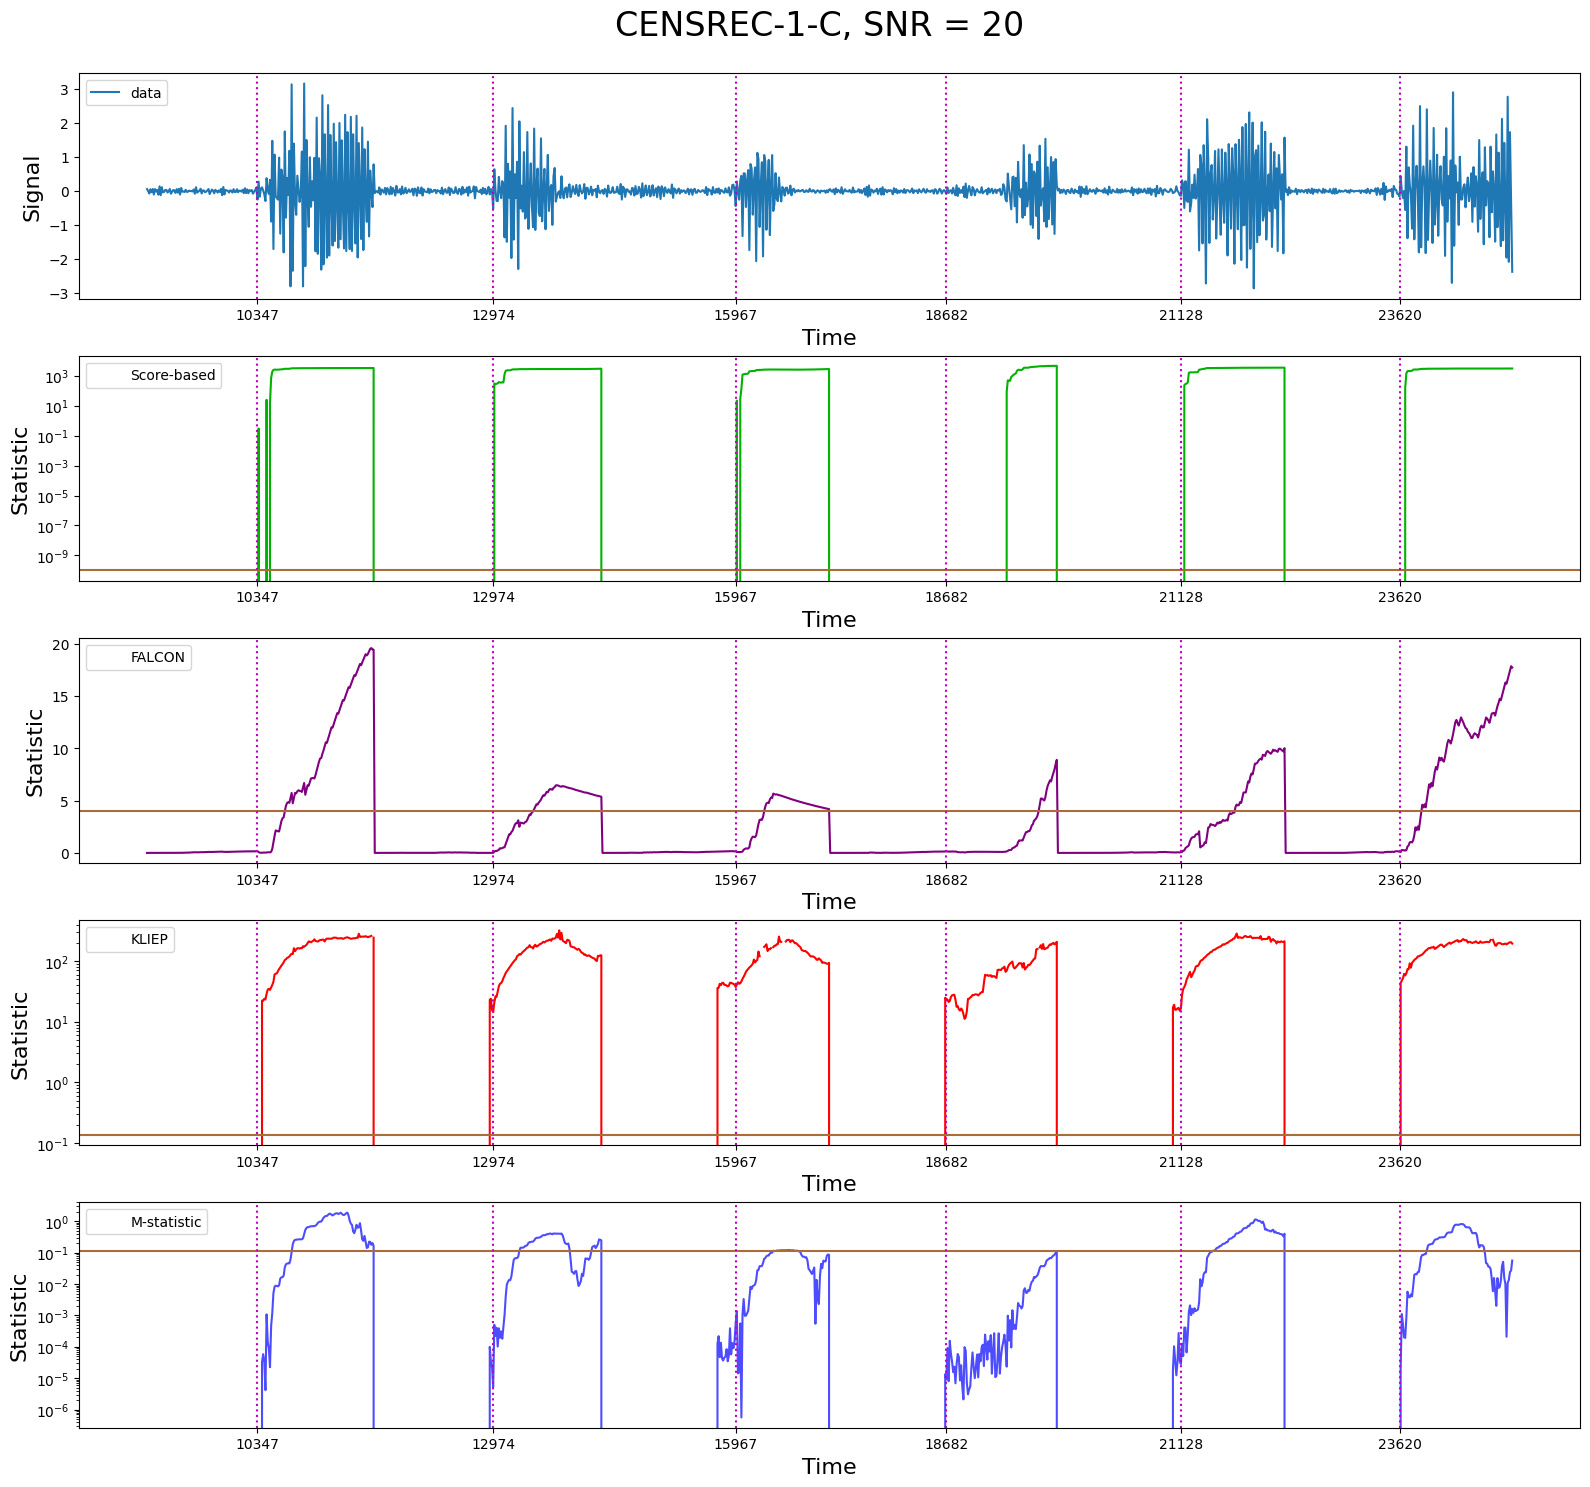

In [63]:
f, ax = plt.subplots(5, 1, figsize=(16, 15))

plt.suptitle(t='CENSREC-1-C, SNR = 20', fontsize=24, y=0.98)
f.tight_layout(pad=2.0)

ax[0].plot(test_for_plot, label='data')


ax[1].plot(s_q_test, c='#00b300')
ax[1].axhline(z_q, c='#aa6c39')
ax[1].plot(z_q, lw=0, label="Score-based")
# ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) 
ax[1].set_yscale('log')


ax[2].plot(s_ftal_test, c='purple')
ax[2].axhline(z_ftal, c='#aa6c39')
ax[2].plot(z_ftal, lw=0, label="FALCON")
# ax[2].set_yscale('log')

ax[3].plot(s_kliep_test, c='red')
ax[3].axhline(z_kliep, c='#aa6c39')
ax[3].plot(z_kliep, lw=0, label="KLIEP")
ax[3].set_yscale('log')

ax[4].plot(s_mmd_test, c='#4d4dff')
ax[4].axhline(z_mmd, c='#aa6c39')
ax[4].plot(z_mmd, lw=0, label="M-statistic")
ax[4].set_yscale('log')

for i in range(5):
    for c in cptest:
        ax[i].axvline(c, c='m', ls=':')
    ax[i].set_xticks(cptest, tick_cps_labels)
    if i == 0:
        ax[i].set_ylabel('Signal', fontsize=16)
    else:
        ax[i].set_ylabel('Statistic', fontsize=16)
    ax[i].set_xlabel('Time', fontsize=16)
    # ax[i].grid()

    
    
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()

plt.show()
